<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/RandomForest_52wkHighlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
!pip install yfinance

In [128]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [129]:
START = "2013-01-01"  #yyyy-mm-dd
END = '2020-06-01'
START_testdate='2020-10-01'

In [130]:
nifty=yf.download('^nsei',start=START,end=END)

[*********************100%***********************]  1 of 1 completed


In [131]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty100list.csv')

In [132]:
ticker.tail(2)

,Company Name,Industry,Symbol,Series,ISIN Code
98,Wipro Ltd.,IT,WIPRO,EQ,INE075A01022
99,Yes Bank Ltd.,FINANCIAL SERVICES,YESBANK,EQ,INE528G01035


In [133]:
#Download Data From Yahoo Finance
lst=[]
for i in range(len(ticker)):
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
   
  dfi['result']=dfi['High'].rolling(window=50, min_periods=1).max()
  dfi['result_low']=dfi['Low'].rolling(window=50, min_periods=1).min()
  dfi['high52']=np.where(dfi['High']>=dfi['result'],1,0)
  dfi['low52']=np.where(dfi['Low']<=dfi['result_low'],1,0)
  dfi = dfi.dropna()
   
  #df.head(3)
  #print('Done : '+ nifty10[i])
  #print(df.head(2))
  lst.append(dfi)

#df1.head(3)
print('\n All Completed \n')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [134]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].high52)
  nlst.append(lst[i].low52)


In [135]:
df = pd.DataFrame(nlst).T
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('high_'+str(i))
  namelist.append('low_'+str(i))
df.columns = namelist

In [136]:
def get_sum(df,ema_interval,strng='newhigh'):
  var = strng+f'_ema{ema_interval}'
  df[var] = df['newhigh'].ewm(span=ema_interval, adjust=False).mean()
  return df


In [137]:
df=df[1:].fillna(0)

In [138]:
features = df.columns.tolist()

In [139]:
feats_set1=[feats for feats in features if feats.startswith('high')]

In [140]:
feats_set2=[feats for feats in features if feats.startswith('low')]

In [141]:
df_high=df[feats_set1]

In [142]:
df_low=df[feats_set2]

In [143]:
df['newhigh']=df_high.sum(axis=1)

In [144]:
df['newlow']=df_low.sum(axis=1)
                        

In [145]:
df_new=df[['newhigh','newlow']]

In [146]:
df_new.tail(2)

,newhigh,newlow
Date,,
2021-11-02,2.0,1.0
2021-11-03,4.0,3.0


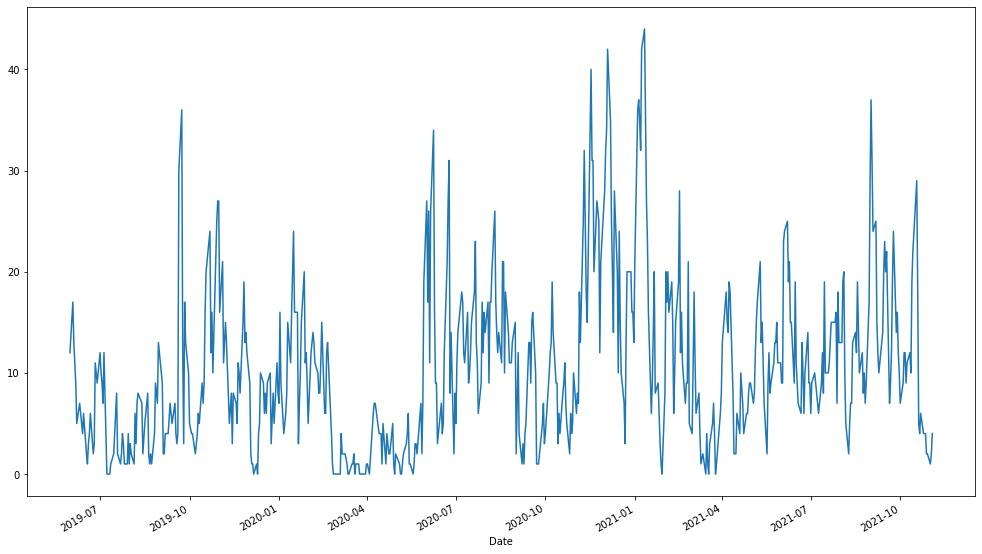

In [147]:
df_new.newhigh[-600:].plot(figsize=(17,10));

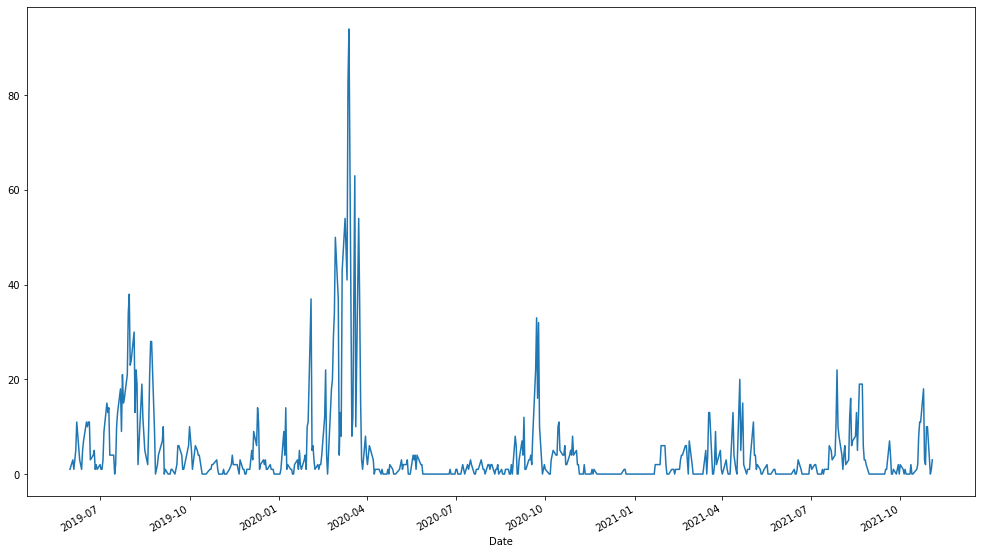

In [148]:
df_new.newlow[-600:].plot(figsize=(17,10));

In [ ]:
df_new=get_sum(df_new,5)
df_new=get_sum(df_new,10)
df_new=get_sum(df_new,15)
df_new=get_sum(df_new,20)
df_new=get_sum(df_new,25)
df_new=get_sum(df_new,30)
df_new=get_sum(df_new,35)
df_new=get_sum(df_new,40)
df_new=get_sum(df_new,45)
df_new=get_sum(df_new,50)
df_new=get_sum(df_new,5,'newlow')
df_new=get_sum(df_new,10,'newlow')
df_new=get_sum(df_new,15,'newlow')
df_new=get_sum(df_new,20,'newlow')
df_new=get_sum(df_new,25,'newlow')
df_new=get_sum(df_new,30,'newlow')
df_new=get_sum(df_new,35,'newlow')
df_new=get_sum(df_new,40,'newlow')
df_new=get_sum(df_new,45,'newlow')
df_new=get_sum(df_new,50,'newlow')

In [150]:
df_new.tail(2)

,newhigh,newlow,newhigh_ema5,newhigh_ema10,newhigh_ema15,newhigh_ema20,newhigh_ema25,newhigh_ema30,newhigh_ema35,newhigh_ema40,newhigh_ema45,newhigh_ema50,newlow_ema5,newlow_ema10,newlow_ema15,newlow_ema20,newlow_ema25,newlow_ema30,newlow_ema35,newlow_ema40,newlow_ema45,newlow_ema50
Date,,,,,,,,,,,,,,,,,,,,,,
2021-11-02,2.0,1.0,2.492871,4.647583,6.412949,7.715940,8.688898,9.423697,9.983606,10.413739,10.746779,11.006687,2.492871,4.647583,6.412949,7.715940,8.688898,9.423697,9.983606,10.413739,10.746779,11.006687
2021-11-03,4.0,3.0,2.995247,4.529841,6.111330,7.362041,8.328214,9.073781,9.651184,10.100874,10.453441,10.731915,2.995247,4.529841,6.111330,7.362041,8.328214,9.073781,9.651184,10.100874,10.453441,10.731915


In [151]:
price_data=df_new.copy()

In [152]:
price_data=pd.concat([price_data,nifty['Close']],axis=1)

In [153]:
feats_ml = price_data.columns.tolist()

In [154]:
# define the number of days out you want to predict
days_out =14

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
price_data['Signal_Flag'] = price_data['Close'].transform(lambda x : np.sign(x.diff(days_out)))
#price_data['Signal_Flag_INR'] = price_data['INRClose'].transform(lambda x : np.sign(x.diff(days_out)))
# print the first 50 rows

In [155]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.tail(3)

,newhigh,newlow,newhigh_ema5,newhigh_ema10,newhigh_ema15,newhigh_ema20,newhigh_ema25,newhigh_ema30,newhigh_ema35,newhigh_ema40,newhigh_ema45,newhigh_ema50,newlow_ema5,newlow_ema10,newlow_ema15,newlow_ema20,newlow_ema25,newlow_ema30,newlow_ema35,newlow_ema40,newlow_ema45,newlow_ema50,Close,Signal_Flag,Prediction
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-01,1.0,0.0,2.739306,5.235935,7.043370,8.317618,9.246306,9.935676,10.453230,10.845213,11.144360,11.374307,2.739306,5.235935,7.043370,8.317618,9.246306,9.935676,10.453230,10.845213,11.144360,11.374307,NaN,NaN,NaN
2021-11-02,2.0,1.0,2.492871,4.647583,6.412949,7.715940,8.688898,9.423697,9.983606,10.413739,10.746779,11.006687,2.492871,4.647583,6.412949,7.715940,8.688898,9.423697,9.983606,10.413739,10.746779,11.006687,NaN,NaN,NaN
2021-11-03,4.0,3.0,2.995247,4.529841,6.111330,7.362041,8.328214,9.073781,9.651184,10.100874,10.453441,10.731915,2.995247,4.529841,6.111330,7.362041,8.328214,9.073781,9.651184,10.100874,10.453441,10.731915,NaN,NaN,NaN


In [156]:

# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {}  columns in original dataset'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns in original dataset'.format(price_data.shape[0], price_data.shape[1]))


Before NaN Drop we have 2177 rows and 25  columns in original dataset
After NaN Drop we have 1785 rows and 25 columns in original dataset


In [157]:
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [158]:
feats_ml

['newhigh',
 'newlow',
 'newhigh_ema5',
 'newhigh_ema10',
 'newhigh_ema15',
 'newhigh_ema20',
 'newhigh_ema25',
 'newhigh_ema30',
 'newhigh_ema35',
 'newhigh_ema40',
 'newhigh_ema45',
 'newhigh_ema50',
 'newlow_ema5',
 'newlow_ema10',
 'newlow_ema15',
 'newlow_ema20',
 'newlow_ema25',
 'newlow_ema30',
 'newlow_ema35',
 'newlow_ema40',
 'newlow_ema45',
 'newlow_ema50',
 'Close']

In [159]:
X_Cols = price_data[feats_ml]
Y_Cols = price_data['Prediction']
#,'log5vol','log5','RSI','Price_Rate_Of_Change','log5volM','log5M','MMI_roc'
# Split X and y into X_train and X_test
samp_train= int(len(price_data)*.75) -50
samp_test= samp_train+50
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]


#X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)


# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
'''
# Fit the random search model############################~~~~~~~~~~~~~~~~~~################
rf_random.fit(X_train, y_train)
print(f"Best score: {rf_random.best_score_}")
print("Best parameters set:")
best_parameters = rf_random.best_estimator_.get_params()
for param_name in sorted(random_grid.keys()):
  print(f"\t{param_name}: {best_parameters[param_name]}")
'''

'\n# Fit the random search model############################~~~~~~~~~~~~~~~~~~################\nrf_random.fit(X_train, y_train)\nprint(f"Best score: {rf_random.best_score_}")\nprint("Best parameters set:")\nbest_parameters = rf_random.best_estimator_.get_params()\nfor param_name in sorted(random_grid.keys()):\n  print(f"\t{param_name}: {best_parameters[param_name]}")\n'

In [160]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 1200,max_depth=80,min_samples_leaf=1,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)

In [161]:
samp_train,samp_test

(1288, 1338)

In [162]:
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.748691,0.733333,0.740933,195.000000
Up Day,0.796875,0.809524,0.803150,252.000000
accuracy,0.776286,0.776286,0.776286,0.776286
macro avg,0.772783,0.771429,0.772041,447.000000
weighted avg,0.775855,0.776286,0.776008,447.000000


Accuracy: 0.7762863534675615
Percision: 0.796875
Recall: 0.8095238095238095
Specificity: 0.7333333333333333


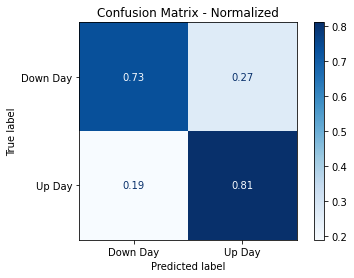

In [163]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [164]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

newhigh_ema5     0.150844
newlow_ema5      0.139185
newlow_ema10     0.096718
newlow           0.094362
newhigh_ema10    0.085714
newhigh          0.050539
newhigh_ema15    0.046175
newlow_ema15     0.042859
newhigh_ema20    0.029889
newlow_ema25     0.025628
Close            0.025339
newlow_ema20     0.024747
newhigh_ema25    0.022314
newlow_ema30     0.020199
newhigh_ema30    0.018968
newlow_ema50     0.018005
newhigh_ema50    0.017884
newlow_ema45     0.016227
newlow_ema35     0.016116
newhigh_ema35    0.015610
newhigh_ema45    0.015452
newlow_ema40     0.013911
newhigh_ema40    0.013317
dtype: float64

In [165]:
Ticker = '^NSEI'
nifty_n = yf.download(Ticker, start=START_testdate)
nifty_n=nifty_n.dropna()
nifty_n=nifty_n.iloc[:,:4]

[*********************100%***********************]  1 of 1 completed


In [166]:
#Download Data From Yahoo Finance
lst_test=[]
for i in range(len(ticker)):
  dfi_test = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START_testdate)
   
  dfi_test['result']=dfi_test['High'].rolling(window=50, min_periods=1).max()
  dfi_test['result_low']=dfi_test['Low'].rolling(window=50, min_periods=1).min()
  dfi_test['high52']=np.where(dfi_test['High']>=dfi_test['result'],1,0)
  dfi_test['low52']=np.where(dfi_test['Low']<=dfi_test['result_low'],1,0)
  dfi_test = dfi_test.dropna()
   
  #df.head(3)
  #print('Done : '+ nifty10[i])
  #print(df.head(2))
  lst_test.append(dfi_test)

#df1.head(3)
print('\n All Completed \n')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [167]:
nlst_test=[]
for i in range(len(ticker)):
  nlst_test.append(lst_test[i].high52)
  nlst_test.append(lst_test[i].low52)

In [168]:
df_test= pd.DataFrame(nlst_test).T
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('high_'+str(i))
  namelist.append('low_'+str(i))
df_test.columns = namelist

In [169]:
df_test=df_test[1:].fillna(0)

In [170]:
features = df_test.columns.tolist()

In [171]:
feats_set1=[feats for feats in features if feats.startswith('high')]

In [172]:
feats_set2=[feats for feats in features if feats.startswith('low')]

In [173]:
df_high_test=df_test[feats_set1]

In [174]:
df_low_test=df_test[feats_set2]

In [175]:
df_test['newhigh']=df_high_test.sum(axis=1)

In [176]:
df_test['newlow']=df_low_test.sum(axis=1)

In [177]:
df_new_test=df_test[['newhigh','newlow']]

In [178]:
df_new_test=get_sum(df_new_test,5)
df_new_test=get_sum(df_new_test,10)
df_new_test=get_sum(df_new_test,15)
df_new_test=get_sum(df_new_test,20)
df_new_test=get_sum(df_new_test,25)
df_new_test=get_sum(df_new_test,30)
df_new_test=get_sum(df_new_test,35)
df_new_test=get_sum(df_new_test,40)
df_new_test=get_sum(df_new_test,45)
df_new_test=get_sum(df_new_test,50)
df_new_test=get_sum(df_new_test,5,'newlow')
df_new_test=get_sum(df_new_test,10,'newlow')
df_new_test=get_sum(df_new_test,15,'newlow')
df_new_test=get_sum(df_new_test,20,'newlow')
df_new_test=get_sum(df_new_test,25,'newlow')
df_new_test=get_sum(df_new_test,30,'newlow')
df_new_test=get_sum(df_new_test,35,'newlow')
df_new_test=get_sum(df_new_test,40,'newlow')
df_new_test=get_sum(df_new_test,45,'newlow')
df_new_test=get_sum(df_new_test,50,'newlow')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
df_new_test.tail(2)

,newhigh,newlow,newhigh_ema5,newhigh_ema10,newhigh_ema15,newhigh_ema20,newhigh_ema25,newhigh_ema30,newhigh_ema35,newhigh_ema40,newhigh_ema45,newhigh_ema50,newlow_ema5,newlow_ema10,newlow_ema15,newlow_ema20,newlow_ema25,newlow_ema30,newlow_ema35,newlow_ema40,newlow_ema45,newlow_ema50
Date,,,,,,,,,,,,,,,,,,,,,,
2021-11-02,2.0,1.0,2.492871,4.647583,6.412949,7.715940,8.688898,9.423699,9.983633,10.413897,10.747424,11.008677,2.492871,4.647583,6.412949,7.715940,8.688898,9.423699,9.983633,10.413897,10.747424,11.008677
2021-11-03,4.0,3.0,2.995247,4.529841,6.111330,7.362041,8.328214,9.073783,9.651209,10.101024,10.454058,10.733827,2.995247,4.529841,6.111330,7.362041,8.328214,9.073783,9.651209,10.101024,10.454058,10.733827


In [180]:
price_data_new = df_new_test.copy()
price_data_new=pd.concat([price_data_new,nifty_n['Close']],axis=1)

In [181]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

In [182]:
ppp =price_data_new.reset_index()
ppp.head(2)

,Date,newhigh,newlow,newhigh_ema5,newhigh_ema10,newhigh_ema15,newhigh_ema20,newhigh_ema25,newhigh_ema30,newhigh_ema35,newhigh_ema40,newhigh_ema45,newhigh_ema50,newlow_ema5,newlow_ema10,newlow_ema15,newlow_ema20,newlow_ema25,newlow_ema30,newlow_ema35,newlow_ema40,newlow_ema45,newlow_ema50,Close,Prediction
0,2020-10-22,20.0,16.0,19.504523,23.437875,29.390883,34.637254,38.897478,42.329144,45.119917,47.420697,49.343962,50.972455,19.504523,23.437875,29.390883,34.637254,38.897478,42.329144,45.119917,47.420697,49.343962,50.972455,11896.450195,1.0
1,2020-10-23,20.0,5.0,19.669682,22.812807,28.217023,33.243229,37.443826,40.888554,43.724366,46.083102,48.068137,49.757848,19.669682,22.812807,28.217023,33.243229,37.443826,40.888554,43.724366,46.083102,48.068137,49.757848,11930.349609,1.0


In [183]:
pred = pd.DataFrame(rand_frst_clf.predict(price_data_new[feats_ml]))
pred = pd.concat([pred , ppp.Date,ppp.Close],axis=1)
pred.columns=['pred','Date','Close']
pred= pred.set_index('Date')

In [184]:
l=len(pred)

Text(0.5, 0.98, 'Random Forest New High New Low')

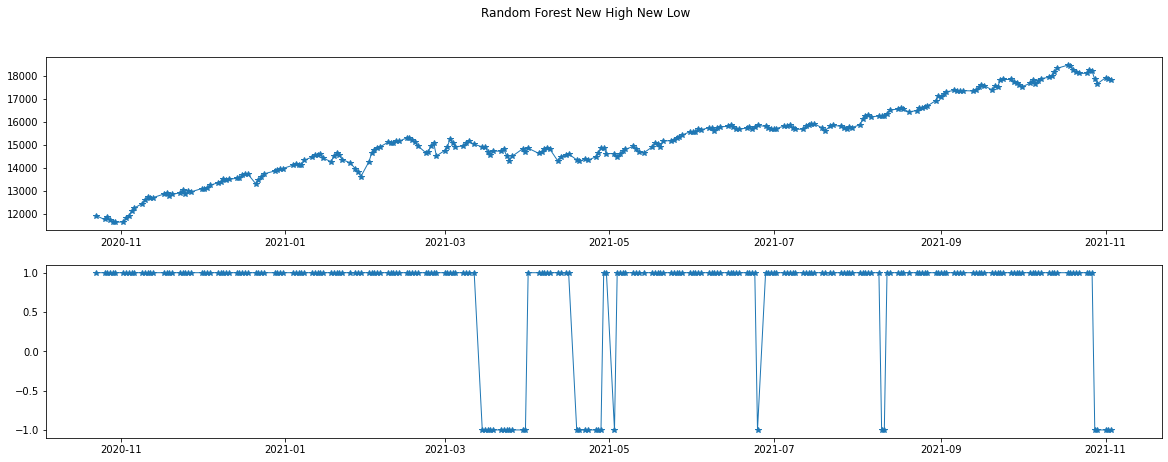

In [185]:
fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(nifty_n.index.values[-l:],nifty_n['Close'].values[-l:],'*-',linewidth=1 )
ax[1].plot(nifty_n.index.values[-l:],pred.pred.values[-l:],'*-',linewidth=1 )
plt.suptitle('Random Forest New High New Low')
#plt.savefig('LIX.png')


In [186]:
pred['Buy_ind'] = np.where((pred['pred']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['pred']==-1), 0, 1)

In [187]:
pred=pred.reset_index()

In [188]:
nifty_n['50_EMA'] = nifty_n["Close"].rolling(50).mean()

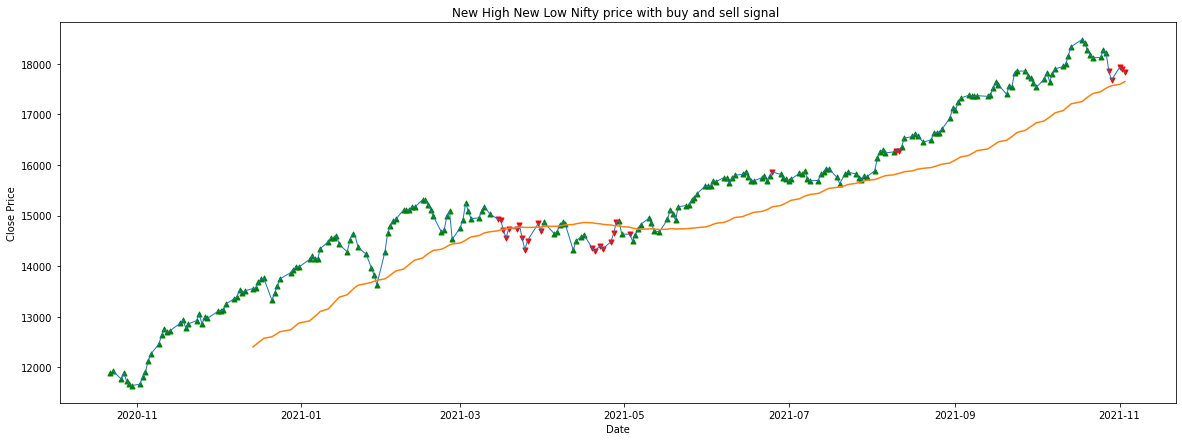

In [189]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(nifty_n.index.values[-l:],nifty_n['Close'].values[-l:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=25, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=25, marker="v")
plt.plot(nifty_n.index.values[-l:],nifty_n['50_EMA'].values[-l:])
## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('New High New Low Nifty price with buy and sell signal ' ) 
plt.show();